In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#gensim
from gensim.parsing.preprocessing import remove_stopwords



# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
df = pd.read_csv("Data/training.1600000.processed.noemoticon.csv",encoding="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
len(df)

1600000

In [5]:
decode_map = {4:"positive",0:"negative",2:"neutral"}
def decodesentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x : decodesentiment(x))

CPU times: total: 406 ms
Wall time: 436 ms


In [7]:
df.target

0          negative
1          negative
2          negative
3          negative
4          negative
             ...   
1599995    positive
1599996    positive
1599997    positive
1599998    positive
1599999    positive
Name: target, Length: 1600000, dtype: object

In [8]:
target_count = Counter(df.target)

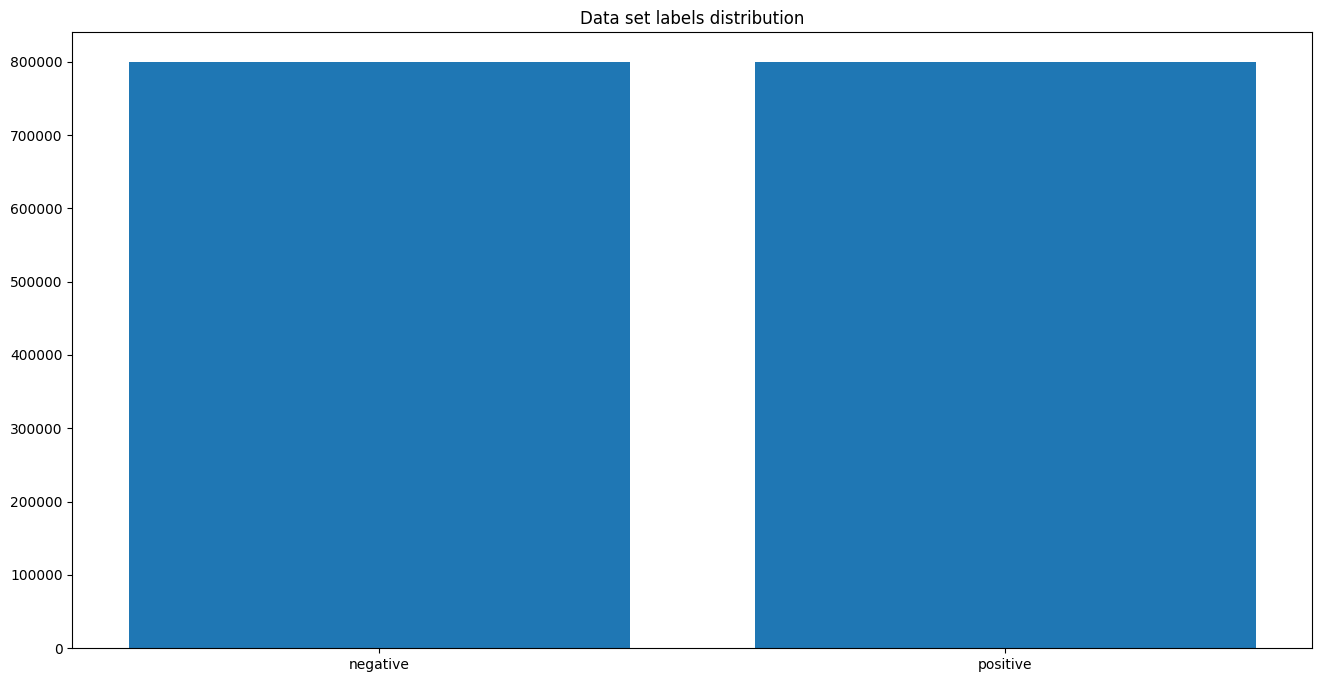

In [9]:
plt.figure(figsize=(16,8))
plt.bar(target_count.keys(),target_count.values())
plt.title("Data set labels distribution")
plt.show()

In [10]:
stemmer = SnowballStemmer("english")

In [11]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text,stem=False):
    text=re.sub(TEXT_CLEANING_RE,' ',str(text).lower()).strip()
    tokens=[]
    text=remove_stopwords(text)
    for token in text:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return "".join(tokens)

In [12]:
%%time
df.text=df.text.apply(lambda x : preprocess(x))

CPU times: total: 59.3 s
Wall time: 1min 24s


In [13]:
df.text

0                 awww s bummer shoulda got david carr day d
1          upset t update facebook texting result school ...
2               dived times ball managed save 50 rest bounds
3                                      body feels itchy like
4                                         s behaving m mad t
                                 ...                        
1599995                      woke having school best feeling
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

In [14]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
print("Train Size",len(df_train))
print("Test Size",len(df_test))

Train Size 1280000
Test Size 320000


In [15]:
%%time
documents = [x.split() for x in df_train.text]

CPU times: total: 2.83 s
Wall time: 4.15 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300,window=7,min_count=10,workers=8)

2023-12-09 17:29:28,423 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-12-09T17:29:28.422117', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [17]:
w2v_model.build_vocab(documents)

2023-12-09 17:29:28,438 : INFO : collecting all words and their counts
2023-12-09 17:29:28,441 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-09 17:29:28,490 : INFO : PROGRESS: at sentence #10000, processed 68563 words, keeping 13862 word types
2023-12-09 17:29:28,518 : INFO : PROGRESS: at sentence #20000, processed 136480 words, keeping 21432 word types
2023-12-09 17:29:28,544 : INFO : PROGRESS: at sentence #30000, processed 203915 words, keeping 27383 word types
2023-12-09 17:29:28,566 : INFO : PROGRESS: at sentence #40000, processed 272195 words, keeping 32604 word types
2023-12-09 17:29:28,592 : INFO : PROGRESS: at sentence #50000, processed 339920 words, keeping 37427 word types
2023-12-09 17:29:28,621 : INFO : PROGRESS: at sentence #60000, processed 407425 words, keeping 42036 word types
2023-12-09 17:29:28,657 : INFO : PROGRESS: at sentence #70000, processed 474949 words, keeping 46296 word types
2023-12-09 17:29:28,688 : INFO : PROGRESS: at s

In [18]:
words = list(w2v_model.wv.index_to_key)
vocab_size=len(words)
print("Vocab size",vocab_size)

Vocab size 30199


In [19]:
%%time
w2v_model.train(documents,total_examples=len(documents),epochs=32)

2023-12-09 17:29:32,753 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30199 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-12-09T17:29:32.753209', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
2023-12-09 17:29:33,826 : INFO : EPOCH 0 - PROGRESS: at 9.77% examples, 715315 words/s, in_qsize 14, out_qsize 1
2023-12-09 17:29:34,839 : INFO : EPOCH 0 - PROGRESS: at 19.30% examples, 710826 words/s, in_qsize 15, out_qsize 0
2023-12-09 17:29:35,837 : INFO : EPOCH 0 - PROGRESS: at 29.86% examples, 737921 words/s, in_qsize 15, out_qsize 0
2023-12-09 17:29:36,846 : INFO : EPOCH 0 - PROGRESS: at 39.83% examples, 739343 words/s, in_qsize 15, out_qsize 0
2023-12-09 17:29:37,873 : INFO : EPOCH 0 - PROGRESS: at 48.54% examples, 719381 words/s, in_qsize 13, out_qsize 2
2023-12-09 

CPU times: total: 20min 24s
Wall time: 5min 48s


(240432633, 278645568)

In [20]:
w2v_model.wv.most_similar("love")

[('luv', 0.5542714595794678),
 ('loves', 0.546687662601471),
 ('loved', 0.4942888021469116),
 ('adore', 0.48959311842918396),
 ('amazing', 0.489240437746048),
 ('looove', 0.47780850529670715),
 ('loveee', 0.4676510691642761),
 ('lovee', 0.46451428532600403),
 ('awesome', 0.46364396810531616),
 ('loooove', 0.4293340742588043)]

In [21]:
%%time


tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index)+1
print("Total Words",vocab_size)

Total Words 290240
CPU times: total: 13.3 s
Wall time: 13.6 s


In [22]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text),maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen=300)

CPU times: total: 21.9 s
Wall time: 22.9 s


In [23]:
labels=df.target.unique().tolist()
labels.append("neutral")
print(labels)

['negative', 'positive', 'neutral']


In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

Y_train=encoder.transform(df_train.target.tolist())
Y_test=encoder.transform(df_test.target.tolist())

Y_train=Y_train.reshape(-1,1)
Y_test=Y_test.reshape(-1,1)

print("y_train",Y_train.shape)
print("y_test",Y_test.shape)


y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train",X_train.shape)
print("y_train",Y_train.shape)
print()
print("x_test",X_test.shape)
print("y_test",Y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
Y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
embedding_matrix = np.zeros((vocab_size,300)) #word to vec size =300
for word,i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i]=w2v_model.wv[word]
print(embedding_matrix.shape)

(290240, 300)


In [28]:
embedding_layer =Embedding(vocab_size,300,weights=[embedding_matrix],input_length=300,trainable=False)

2023-12-09 17:36:00,239 : WARNING : From C:\Users\abhic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [29]:
model =Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87072000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87232501 (332.77 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87072000 (332.15 MB)
_________________________________________________________________


In [30]:
model.compile( 
loss= 'binary_crossentropy',
optimizer="adam",
metrics= ['accuracy'])

2023-12-09 17:36:05,081 : WARNING : From C:\Users\abhic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [32]:
%%time
history = model.fit(X_train, Y_train,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8



2023-12-09 17:36:12,330 : WARNING : From C:\Users\abhic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



2023-12-09 17:36:13,372 : WARNING : From C:\Users\abhic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



1125/1125 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7519WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 20:37:31,283 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10880s 10s/step - loss: 0.5036 - accuracy: 0.7519 - val_loss: 0.4685 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.7680WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 23:35:45,982 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10695s 10s/step - loss: 0.4788 - accuracy: 0.7680 - val_loss: 0.4586 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.7723WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 02:29:13,932 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10408s 9s/step - loss: 0.4721 - accuracy: 0.7723 - val_loss: 0.4549 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.7748WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 05:15:27,887 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9974s 9s/step - loss: 0.4684 - accuracy: 0.7748 - val_loss: 0.4540 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.7763WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 08:10:19,100 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10491s 9s/step - loss: 0.4661 - accuracy: 0.7763 - val_loss: 0.4542 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.7770WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 11:01:58,347 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10299s 9s/step - loss: 0.4644 - accuracy: 0.7770 - val_loss: 0.4503 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.7784WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 13:59:00,439 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10622s 9s/step - loss: 0.4629 - accuracy: 0.7784 - val_loss: 0.4493 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.7793WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-10 17:00:37,928 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10897s 10s/step - loss: 0.4615 - accuracy: 0.7793 - val_loss: 0.4498 - val_accuracy: 0.7895 - lr: 0.0010
CPU times: total: 3d 2h 33min 47s
Wall time: 23h 24min 32s


In [35]:
%%time 
score = model.evaluate(X_test,Y_test,batch_size=1024)
print()
print("Accuracy : ",score[1])
print("Loss : ",score[0])


313/313 [==============================] - 468s 1s/step - loss: 0.4478 - accuracy: 0.7904

Accuracy :  0.7904468774795532
Loss :  0.4478282332420349
CPU times: total: 28min 7s
Wall time: 7min 49s


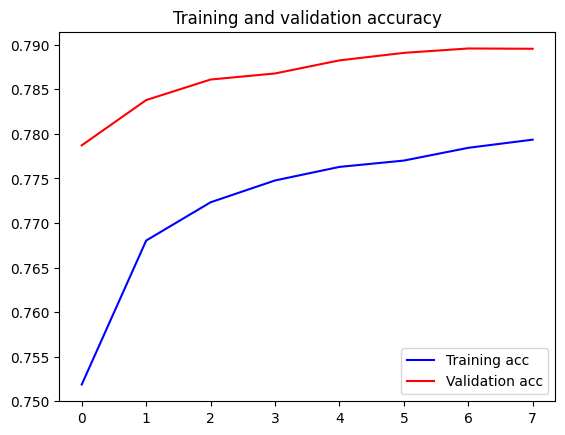

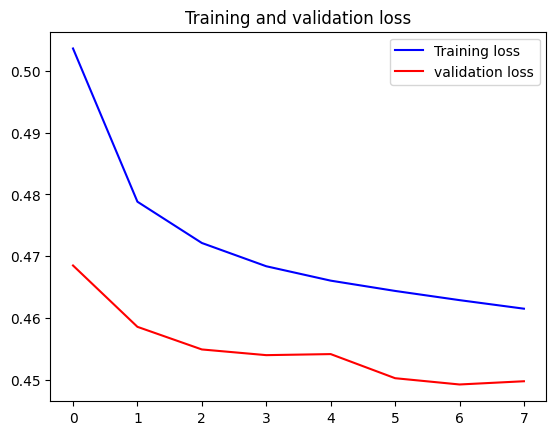

In [39]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [40]:
def decode_sentiment(score,include_neutral=True):
    if include_neutral:
        label = "neutral"
        if score <= 0.4:
            label = "negative"
        elif score >=0.7:
            label = "positive"

        return label
    
    else:
        return "negative" if score<0.5 else "positive"
        

In [49]:
def predict(text,include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=300)
    score=model.predict([x_test])[0]
    label=decode_sentiment(score,include_neutral=include_neutral)
    return {"label":label,"score":float(score),"elapsed_time":time.time()-start_at}

In [50]:
predict("I love cheese")

1/1 [==============================] - 0s 80ms/step


C:\Users\abhic\AppData\Local\Temp\ipykernel_19164\4211083424.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label":label,"score":float(score),"elapsed_time":time.time()-start_at}


{'label': 'positive',
 'score': 0.9307434558868408,
 'elapsed_time': 0.14721345901489258}

In [51]:
predict("I hate eggs")

1/1 [==============================] - 0s 70ms/step


C:\Users\abhic\AppData\Local\Temp\ipykernel_19164\4211083424.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label":label,"score":float(score),"elapsed_time":time.time()-start_at}


{'label': 'negative',
 'score': 0.03735740855336189,
 'elapsed_time': 0.1318049430847168}

In [52]:
predict("but i love chicken")

1/1 [==============================] - 0s 70ms/step


C:\Users\abhic\AppData\Local\Temp\ipykernel_19164\4211083424.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label":label,"score":float(score),"elapsed_time":time.time()-start_at}


{'label': 'positive',
 'score': 0.8859193325042725,
 'elapsed_time': 0.13891339302062988}

In [54]:
%%time
y_pred_1d=[]
y_test_1d=list(df_test.target)
scores=model.predict(X_test,verbose=1,batch_size=8000)
y_pred_1d=[decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 851s 21s/step
CPU times: total: 50min 3s
Wall time: 14min 12s


In [57]:
def plot_confusion_matrix(cm,classes,title='confusion matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

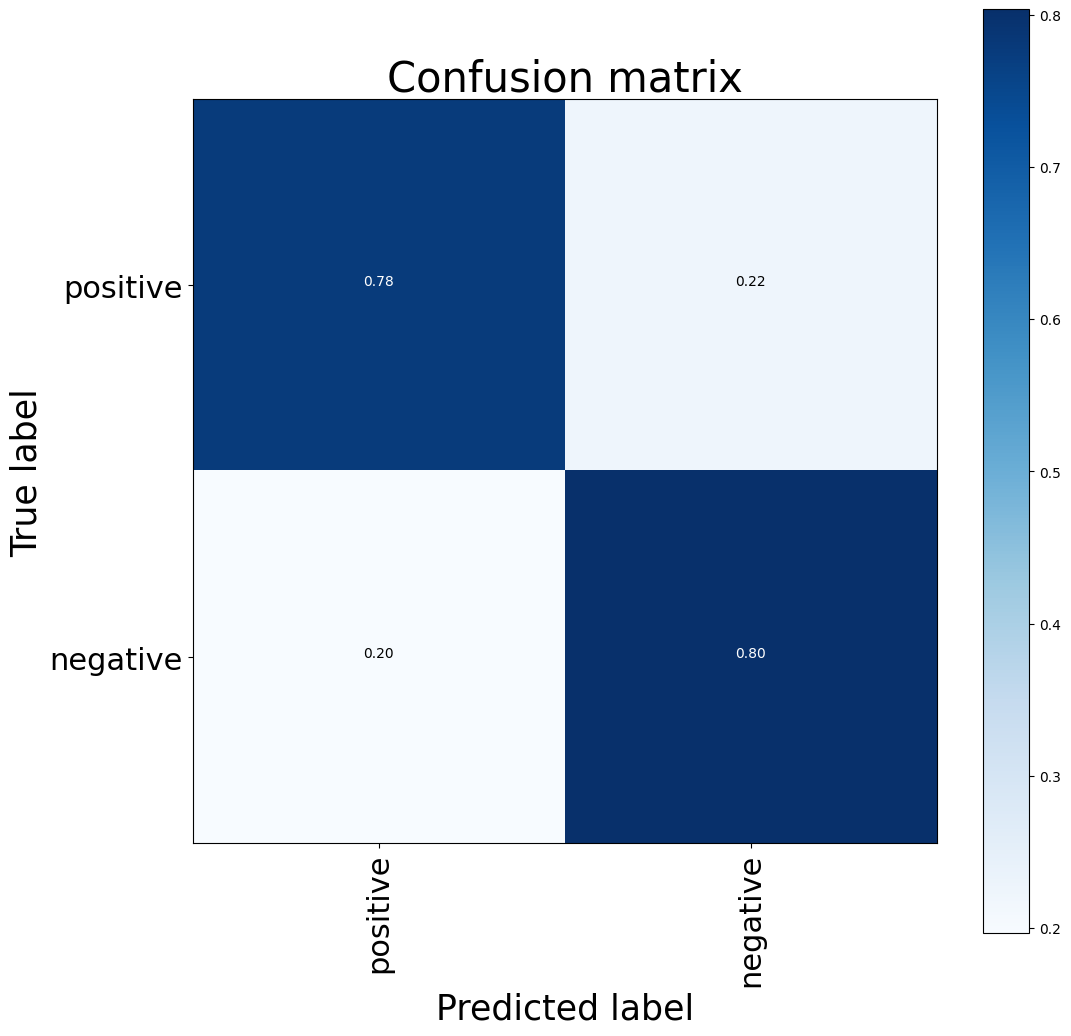

CPU times: total: 1.19 s
Wall time: 1.47 s


In [58]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [59]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79    159494
    positive       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.790446875

In [62]:
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL="model.w2v"
TOKENIZER_MODEL="tokenizer.pkl"
ENCODER_MODEL="encoder.pkl"
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

C:\Users\abhic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-12-10 17:32:08,420 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-12-10T17:32:08.418847', 'gensim': '4.3.2', 'python': '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2023-12-10 17:32:08,437 : INFO : not storing attribute cum_table
2023-12-10 17:32:09,223 : INFO : saved model.w2v
